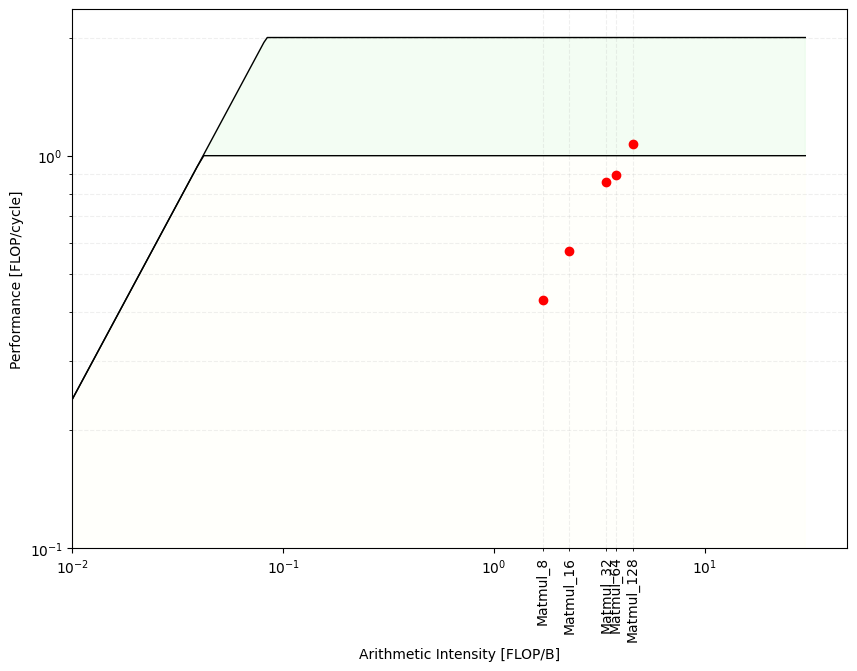

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

with open("data.csv") as f:
    df = pd.read_csv(f, sep=",", skipinitialspace=True)

cluster_tcdm_banks = 32  # Number of TCDM banks per cluster
cc_n_streams = 3  # Number of streams available for a core complex
tcdm_transaction_size = 8  # TCDM transaction transfer size (B)
cluster_peak_bandwidth = (
    cluster_tcdm_banks * tcdm_transaction_size
)  # Peak memory bandwidth (B/cycle)
cc_attainable_bandwidth = (
    cc_n_streams * tcdm_transaction_size
)  # Attainable memory bandwidth by a single core complex (B/cycle)
# Note: the previous number is probably incomplete since we are missing
# the cc > snitch own LSU and the cc > fpss own LSU. It should probably be
# incremented by 2 (no. of additional LSUs) * tcdm_transaction_size.
# Of course, if any of those additional LSUs are operating on data types
# whose size is smaller than tcdm_transaction_size, transacted data is
# going to be wasted.
# FIXME: take data type transacted by additional FPUs into account

nloads = df["fpss_loads"] + df["snitch_loads"]
df["intensity"] = df["fpss_fpu_issues"] / (nloads * tcdm_transaction_size)
df["performance"] = df["fpss_fpu_issues"] / df["cycles"]

peak_bandwidth = cc_n_streams * tcdm_transaction_size  # B/cycle
peak_performance = 2.0  # FLOP/cycle

fig = plt.figure(1, figsize=(10, 7))
plt.clf()
ax = fig.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Arithmetic Intensity [FLOP/B]")
ax.set_ylabel("Performance [FLOP/cycle]")

x = np.linspace(start=0, stop=30, num=10000)

# fma roof
y_fma = np.minimum(x * peak_bandwidth, peak_performance)
ax.plot(x, y_fma, color="black", linestyle="-", linewidth=1)

# non-fma roof
y_nofma = np.minimum(x * peak_bandwidth, peak_performance / 2.0)
ax.plot(x, y_nofma, color="black", linestyle="-", linewidth=1)

ax.fill_between(x, 0, y_nofma, color="lightyellow", alpha=0.1)
ax.fill_between(x, y_nofma, y_fma, color="lightgreen", alpha=0.1)

for _, row in df.iterrows():
    row_x = row["intensity"]
    row_y = row["performance"]
    ax.plot(row_x, row_y, "o", color="red")

# Crop to zone of interest
ax.set_xlim(left=10**-2)
ax.set_ylim(bottom=10**-1)

# Use minor grid to mark data points
ax.set_xticks([row["intensity"] for _, row in df.iterrows()], minor=True)
ax.set_xticklabels(
    [row["name"] for _, row in df.iterrows()], minor=True, rotation="vertical"
)
ax.grid(which="minor", alpha=0.2, linestyle="--")

plt.savefig("images/roofline_single.png")
plt.savefig("images/roofline_single.pdf")
plt.show()